# Convolutional Neural Networks

Sam Foreman
[](https://orcid.org/0000-0002-9981-0876)
(\[[ANL](https://www.anl.gov/)\](<https://alcf.anl.gov/about/people/sam-foreman>))  
Huihuo ZhengCorey AdamsBethany Lusch2025-07-22

## Getting Started

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/saforem2/intro-hpc-bootcamp-2025/blob/main/docs/01-neural-networks/3-conv-nets/index.ipynb)

Up until transformers, convolutions were *the* state of the art in
computer vision.

In many ways and applications they still are!

Large Language Models, which are what we’ll focus on the rest of the
series after this lecture, are really good at ordered, \*tokenized data.
But there is lots of data that isn’t *implicitly* ordered like `images`,
and their more general cousins `graphs`.

Today’s lecture focuses on computer vision models, and particularly on
convolutional neural networks. There are a ton of applications you can
do with these, and not nearly enough time to get into them. Check out
the extra references file to see some publications to get you started if
you want to learn more.

Tip: this notebook is much faster on the GPU!

## Convolutional Networks: A brief historical context

Performance on ImageNet over time\[^image-net-historical\]

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina', 'svg', 'png')
import os
os.environ["TRUECOLOR"] = "1"
import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 400

In [2]:
import logging

import ambivalent
import ezpz
import matplotlib.pyplot as plt
import seaborn as sns
from rich import print

sns.set_context("notebook")
# sns.set(rc={"figure.dpi": 400, "savefig.dpi": 400})
plt.style.use(ambivalent.STYLES["ambivalent"])
plt.rcParams["figure.figsize"] = [6.4, 4.8]
plt.rcParams["figure.facecolor"] = "none"

[ 2025-08-04 12:29:17,617339 ][ I ][ ezpz / __init__ : 265 : ezpz ] Setting logging level to 'INFO' on 'RANK == 0'

[ 2025-08-04 12:29:17,619494 ][ I ][ ezpz / __init__ : 266 : ezpz ] Setting logging level to 'CRITICAL' on all others 'RANK != 0'

In [3]:
# Data
data = {2010: 28, 2011: 26, 2012: 16, 2013: 12, 2014: 7, 2015: 3, 2016: 2.3, 2017: 2.1}
human_error_rate = 5
plt.bar(list(data.keys()), list(data.values()), color="blue")
plt.axhline(y=human_error_rate, color="red", linestyle="--", label="Human error rate")
plt.xlabel("Year")
plt.ylabel("ImageNet Visual Recognition Error Rate (%)")
plt.title("ImageNet Error Rates Over Time")
plt.legend()
plt.show()

## Convolutional Building Blocks

In [4]:
import torch
import torchvision

We’re going to go through some examples of building blocks for
convolutional networks. To help illustate some of these, let’s use an
image for examples:

In [5]:
from PIL import Image

# wget line useful in Google Colab
#! wget https://raw.githubusercontent.com/argonne-lcf/ai-science-training-series/main/03_advanced_neural_networks/ALCF-Staff.jpg
alcf_image = Image.open("ALCF-Staff.jpg")

In [6]:
from matplotlib import pyplot as plt

fx, fy = plt.rcParamsDefault["figure.figsize"]
figure = plt.figure(figsize=(1.5 * fx, 1.5 * fy))
_ = plt.imshow(alcf_image)

### Convolutions

$$
\begin{equation}
G\left[m, n\right] = \left(f \star h\right)\left[m, n\right] = \sum_{j} \sum_{k} h\left[j, k\right] f\left[m - j, n - k\right]
\end{equation}
$$

Convolutions are a restriction of - and a specialization of - dense
linear layers. A convolution of an image produces another image, and
each output pixel is a function of only it’s local neighborhood of
points. This is called an *inductive bias* and is a big reason why
convolutions work for image data: neighboring pixels are correlated and
you can operate on just those pixels at a time.

$G\left[m, n\right] = \left(f \star h\right)\left[m, n\right] = \sum_{j} \sum_{k} h\left[j, k\right] f\left[m - j, n - k\right]$

See examples of convolutions
[here](https://github.com/vdumoulin/conv_arithmetic)

<figure>
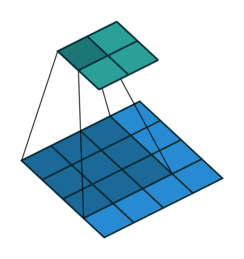
<figcaption aria-hidden="true">image.png</figcaption>
</figure>

In [7]:
# Let's apply a convolution to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)

# Create a random convolution:
# shape is: (channels_in, channels_out, kernel_x, kernel_y)
conv_random = torch.rand((3, 3, 15, 15))

alcf_rand = torch.nn.functional.conv2d(alcf_tensor, conv_random)
alcf_rand = (1.0 / alcf_rand.max()) * alcf_rand
print(alcf_rand.shape)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1, 2, 0)).cpu()
fx, fy = plt.rcParamsDefault["figure.figsize"]
figure = plt.figure(figsize=(1.5 * fx, 1.5 * fy))
_ = plt.imshow(rand_image)

torch.Size ([ 1 , 3 , 1111 , 1986 ])

torch.Size ([ 1 , 3 , 1125 , 2000 ])

### Normalization

Normalization is the act of transforming the mean and moment of your
data to standard values (usually 0.0 and 1.0). It’s particularly useful
in machine learning since it stabilizes training, and allows higher
learning rates.

<figure>
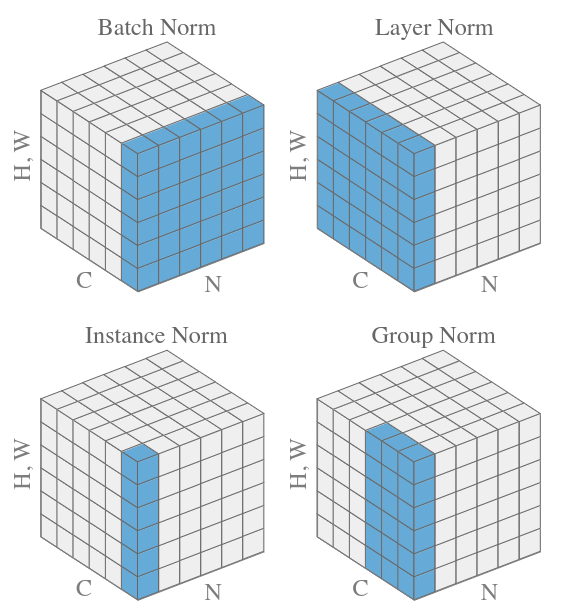
<figcaption aria-hidden="true">Batch Norm</figcaption>
</figure>

Figure 1: Reference:
[Normalizations](https://arxiv.org/pdf/1903.10520.pdf)

<figure>
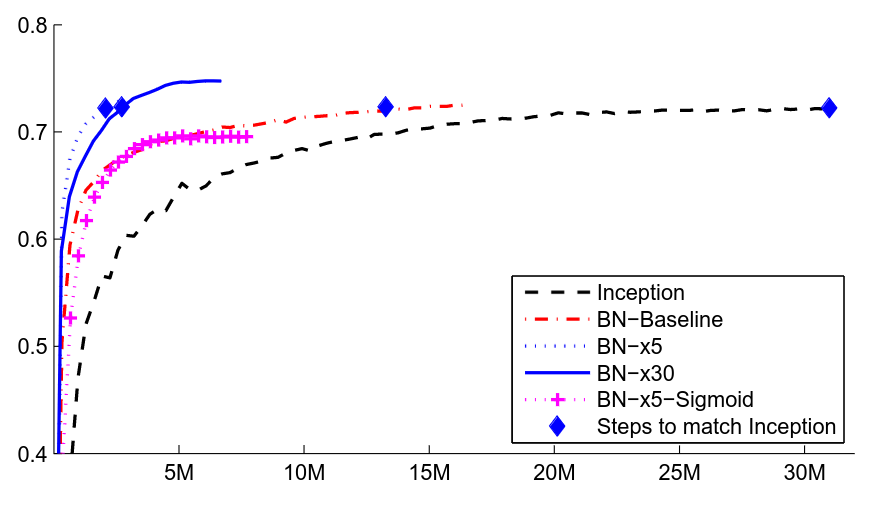
<figcaption aria-hidden="true">Batch Normalization accelerates
training</figcaption>
</figure>

Figure 2: Reference: [Batch Norm](https://arxiv.org/pdf/1502.03167.pdf)

In [8]:
# Let's apply a normalization to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)
# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)
alcf_rand = torch.nn.functional.normalize(alcf_tensor)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])
print(alcf_tensor.shape)
rand_image = alcf_rand.permute((1, 2, 0)).cpu()
fx, fy = plt.rcParamsDefault["figure.figsize"]
figure = plt.figure(figsize=(1.5 * fx, 1.5 * fy))
_ = plt.imshow(rand_image)

torch.Size ([ 1 , 3 , 1125 , 2000 ])

### Downsampling (And upsampling)

Downsampling is a critical component of convolutional and many vision
models. Because of the local-only nature of convolutional filters,
learning large-range features can be too slow for convergence.
Downsampling of layers can bring information from far away closer,
effectively changing what it means to be “local” as the input to a
convolution.

<figure>
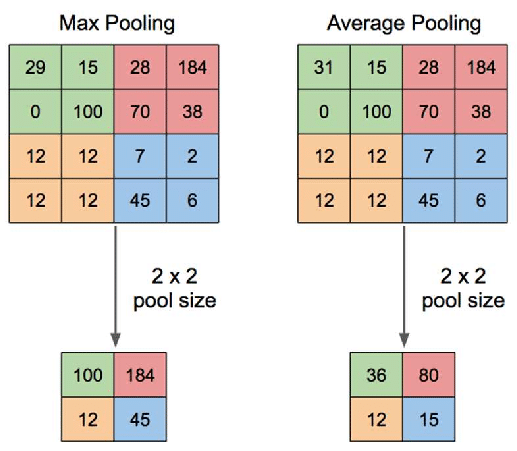
<figcaption aria-hidden="true">Convolutional Pooling</figcaption>
</figure>

Figure 3:
[Reference](https://www.researchgate.net/publication/333593451_Application_of_Transfer_Learning_Using_Convolutional_Neural_Network_Method_for_Early_Detection_of_Terry's_Nail)

In [9]:
# Let's apply a normalization to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)
# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)
alcf_rand = torch.nn.functional.max_pool2d(alcf_tensor, 2)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])
print(alcf_tensor.shape)
rand_image = alcf_rand.permute((1, 2, 0)).cpu()
fx, fy = plt.rcParamsDefault["figure.figsize"]
figure = plt.figure(figsize=(1.5 * fx, 1.5 * fy))
_ = plt.imshow(rand_image)

torch.Size ([ 1 , 3 , 1125 , 2000 ])

### Residual Connections

One issue, quickly encountered when making convolutional networks deeper
and deeper, is the “Vanishing Gradients” problem. As layers were stacked
on top of each other, the size of updates dimished at the earlier layers
of a convolutional network. The paper “Deep Residual Learning for Image
Recognition” solved this by introduction “residual connections” as skip
layers.

Reference: [Deep Residual Learning for Image
Recognition](https://arxiv.org/pdf/1512.03385.pdf)

<figure id="fig-residual-layer">
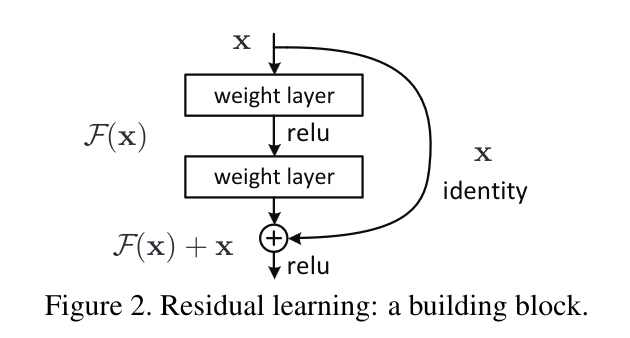
<figcaption>Figure 4: Residual Layer</figcaption>
</figure>

Compare the performance of the models before and after the introduction
of these layers:

<figure id="fig-resnet-performance">
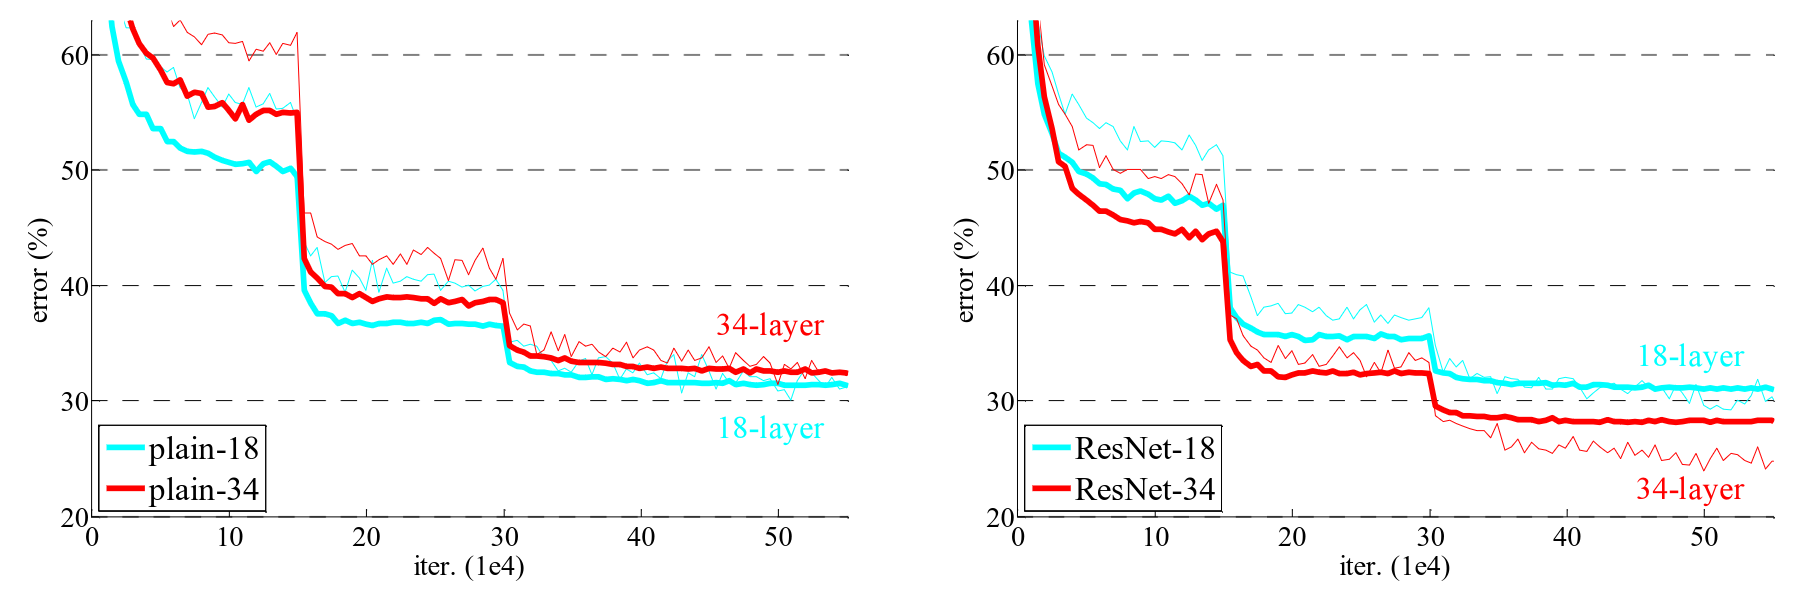
<figcaption>Figure 5</figcaption>
</figure>

If you have time to read only one paper on computer vision, make it this
one! Resnet was the first model to beat human accuracy on ImageNet and
is one of the most impactful papers in AI ever published.

## Building a ConvNet

In this section we’ll build and apply a conv net to the mnist dataset.
The layers here are loosely based off of the ConvNext architecture. Why?
Because we’re getting into LLM’s soon, and this ConvNet uses LLM
features. ConvNext is an update to the ResNet architecture that
outperforms it.

[ConvNext](https://arxiv.org/abs/2201.03545)

The dataset here is CIFAR-10 - slightly harder than MNIST but still
relatively easy and computationally tractable.

In [10]:
batch_size = 16
from torchvision import transforms

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))],
)
training_data = torchvision.datasets.CIFAR10(
    root="data",
    download=True,
    train=True,
    transform=transform,
)

test_data = torchvision.datasets.CIFAR10(
    root="data",
    download=True,
    train=False,
    transform=transform,
)

training_data, validation_data = torch.utils.data.random_split(
    training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55)
)

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(
    training_data,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True,
    num_workers=0,
)
val_dataloader = torch.utils.data.DataLoader(
    validation_data,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=False,
    num_workers=0,
)
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

In [11]:
batch, (X, Y) = next(enumerate(train_dataloader))
plt.imshow(X[0].cpu().permute((1, 2, 0)))
plt.show()

[ 2025-08-04 12:29:50,397009 ][ W ][ matplotlib / image : 661 ] Clipping input data to the valid range for imshow with RGB data ([ 0 .. 1 ] for floats or [ 0 .. 255 ] for integers ) . Got range [ -0.9764706 .. 0.96862745 ] .

In [12]:
import numpy as np


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = next(iter(train_dataloader))

fx, fy = plt.rcParamsDefault["figure.figsize"]
fig = plt.figure(figsize=(2 * fx, 4 * fy))
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("\n" + " ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

dog deer cat truck car horse plane dog car bird bird frog deer bird car plane

This code below is important as our models get bigger: this is wrapping
the pytorch data loaders to put the data onto the GPU!

In [13]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    x = x.view(-1, 3, 32, 32)
    #  y = y.to(dtype)
    return (x.to(dev), y.to(dev))


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)

In [14]:
from typing import Optional

from torch import nn


class Downsampler(nn.Module):
    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()
        self.norm = nn.LayerNorm([in_channels, *shape])
        self.downsample = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=stride,
            stride=stride,
        )

    def forward(self, inputs):
        return self.downsample(self.norm(inputs))


class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:"""

    def __init__(
        self,
        in_channels,
        shape,
        kernel_size: Optional[None] = None,
    ):
        super(ConvNextBlock, self).__init__()
        # Depthwise, seperable convolution with a large number of output filters:
        kernel_size = [7, 7] if kernel_size is None else kernel_size
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=in_channels,
            groups=in_channels,
            kernel_size=kernel_size,
            padding="same",
        )
        self.norm = nn.LayerNorm([in_channels, *shape])
        # Two more convolutions:
        self.conv2 = nn.Conv2d(
            in_channels=in_channels, out_channels=4 * in_channels, kernel_size=1
        )
        self.conv3 = nn.Conv2d(
            in_channels=4 * in_channels, out_channels=in_channels, kernel_size=1
        )

    def forward(self, inputs):
        x = self.conv1(inputs)
        # The normalization layer:
        x = self.norm(x)
        x = self.conv2(x)
        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)
        x = self.conv3(x)
        # This makes it a residual network:
        return x + inputs


class Classifier(nn.Module):
    def __init__(
        self,
        n_initial_filters,
        n_stages,
        blocks_per_stage,
        kernel_size: Optional[None] = None,
    ):
        super(Classifier, self).__init__()
        # This is a downsampling convolution that will produce patches of output.
        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(
            in_channels=3, out_channels=n_initial_filters, kernel_size=1, stride=1
        )
        current_shape = [32, 32]
        self.norm1 = nn.LayerNorm([n_initial_filters, *current_shape])
        # self.norm1 = WrappedLayerNorm()
        current_n_filters = n_initial_filters
        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(
                    ConvNextBlock(
                        in_channels=current_n_filters,
                        shape=current_shape,
                        kernel_size=kernel_size,
                    )
                )
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(
                    Downsampler(
                        in_channels=current_n_filters,
                        out_channels=2 * current_n_filters,
                        shape=current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2 * current_n_filters
                # Cut the shape in half:
                current_shape = [cs // 2 for cs in current_shape]
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10),
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10,
        #                                   kernel_size=1, stride=1)

    def forward(self, x):
        x = self.stem(x)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)
        # Apply the main chunk of the network:
        x = self.layers(x)
        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)
        return x

        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))

In [15]:
from torchinfo import summary

model = Classifier(32, 4, 2, kernel_size=(2, 2))
model.to(device=dev)
print(f"\n{summary(model, input_size=(batch_size, 3, 32, 32))}")

==========================================================================================
Layer ( typ e:de pth-idx ) Output Shape Param #
==========================================================================================
Classifier [ 16 , 10 ] --
├─Conv2d: 1 - 1 [ 16 , 32 , 32 , 32 ] 128 
├─LayerNorm: 1 - 2 [ 16 , 32 , 32 , 32 ] 65 , 536 
├─Sequential: 1 - 3 [ 16 , 256 , 4 , 4 ] --
│ └─ConvNextBlock: 2 - 1 [ 16 , 32 , 32 , 32 ] --
│ │ └─Conv2d: 3 - 1 [ 16 , 32 , 32 , 32 ] 160 
│ │ └─LayerNorm: 3 - 2 [ 16 , 32 , 32 , 32 ] 65 , 536 
│ │ └─Conv2d: 3 - 3 [ 16 , 128 , 32 , 32 ] 4 , 224 
│ │ └─Conv2d: 3 - 4 [ 16 , 32 , 32 , 32 ] 4 , 128 
│ └─ConvNextBlock: 2 - 2 [ 16 , 32 , 32 , 32 ] --
│ │ └─Conv2d: 3 - 5 [ 16 , 32 , 32 , 32 ] 160 
│ │ └─LayerNorm: 3 - 6 [ 16 , 32 , 32 , 32 ] 65 , 536 
│ │ └─Conv2d: 3 - 7 [ 16 , 128 , 32 , 32 ] 4 , 224 
│ │ └─Conv2d: 3 - 8 [ 16 , 32 , 32 , 32 ] 4 , 128 
│ └─Downsampler: 2 - 3 [ 16 , 64 , 16 , 16 ] --
│ │ └─LayerNorm: 3 - 9 [ 16 , 32 , 32 , 32 ] 65 , 536 
│ │ └─Conv2d: 3 - 10 [ 16 , 64 , 16 , 16 ] 8 , 256 
│ └─ConvNextBlock: 2 - 4 [ 16 , 64 , 16 , 16 ] --
│ │ └─Conv2d: 3 - 11 [ 16 , 64 , 16 , 16 ] 320 
│ │ └─LayerNorm: 3 - 12 [ 16 , 64 , 16 , 16 ] 32 , 768 
│ │ └─Conv2d: 3 - 13 [ 16 , 256 , 16 , 16 ] 16 , 640 
│ │ └─Conv2d: 3 - 14 [ 16 , 64 , 16 , 16 ] 16 , 448 
│ └─ConvNextBlock: 2 - 5 [ 16 , 64 , 16 , 16 ] --
│ │ └─Conv2d: 3 - 15 [ 16 , 64 , 16 , 16 ] 320 
│ │ └─LayerNorm: 3 - 16 [ 16 , 64 , 16 , 16 ] 32 , 768 
│ │ └─Conv2d: 3 - 17 [ 16 , 256 , 16 , 16 ] 16 , 640 
│ │ └─Conv2d: 3 - 18 [ 16 , 64 , 16 , 16 ] 16 , 448 
│ └─Downsampler: 2 - 6 [ 16 , 128 , 8 , 8 ] --
│ │ └─LayerNorm: 3 - 19 [ 16 , 64 , 16 , 16 ] 32 , 768 
│ │ └─Conv2d: 3 - 20 [ 16 , 128 , 8 , 8 ] 32 , 896 
│ └─ConvNextBlock: 2 - 7 [ 16 , 128 , 8 , 8 ] --
│ │ └─Conv2d: 3 - 21 [ 16 , 128 , 8 , 8 ] 640 
│ │ └─LayerNorm: 3 - 22 [ 16 , 128 , 8 , 8 ] 16 , 384 
│ │ └─Conv2d: 3 - 23 [ 16 , 512 , 8 , 8 ] 66 , 048 
│ │ └─Conv2d: 3 - 24 [ 16 , 128 , 8 , 8 ] 65 , 664 
│ └─ConvNextBlock: 2 - 8 [ 16 , 128 , 8 , 8 ] --
│ │ └─Conv2d: 3 - 25 [ 16 , 128 , 8 , 8 ] 640 
│ │ └─LayerNorm: 3 - 26 [ 16 , 128 , 8 , 8 ] 16 , 384 
│ │ └─Conv2d: 3 - 27 [ 16 , 512 , 8 , 8 ] 66 , 048 
│ │ └─Conv2d: 3 - 28 [ 16 , 128 , 8 , 8 ] 65 , 664 
│ └─Downsampler: 2 - 9 [ 16 , 256 , 4 , 4 ] --
│ │ └─LayerNorm: 3 - 29 [ 16 , 128 , 8 , 8 ] 16 , 384 
│ │ └─Conv2d: 3 - 30 [ 16 , 256 , 4 , 4 ] 131 , 328 
│ └─ConvNextBlock: 2 - 10 [ 16 , 256 , 4 , 4 ] --
│ │ └─Conv2d: 3 - 31 [ 16 , 256 , 4 , 4 ] 1 , 280 
│ │ └─LayerNorm: 3 - 32 [ 16 , 256 , 4 , 4 ] 8 , 192 
│ │ └─Conv2d: 3 - 33 [ 16 , 1024 , 4 , 4 ] 263 , 168 
│ │ └─Conv2d: 3 - 34 [ 16 , 256 , 4 , 4 ] 262 , 400 
│ └─ConvNextBlock: 2 - 11 [ 16 , 256 , 4 , 4 ] --
│ │ └─Conv2d: 3 - 35 [ 16 , 256 , 4 , 4 ] 1 , 280 
│ │ └─LayerNorm: 3 - 36 [ 16 , 256 , 4 , 4 ] 8 , 192 
│ │ └─Conv2d: 3 - 37 [ 16 , 1024 , 4 , 4 ] 263 , 168 
│ │ └─Conv2d: 3 - 38 [ 16 , 256 , 4 , 4 ] 262 , 400 
├─Sequential: 1 - 4 [ 16 , 10 ] --
│ └─Flatten: 2 - 12 [ 16 , 256 ] --
│ └─LayerNorm: 2 - 13 [ 16 , 256 ] 512 
│ └─Linear: 2 - 14 [ 16 , 10 ] 2 , 570 
==========================================================================================
Total params: 2 , 003 , 914 
Trainable params: 2 , 003 , 914 
Non-trainable params: 0 
Total mult-adds ( Units.GIGABYTES ) : 1.20 
==========================================================================================
Input size ( MB ) : 0.20 
Forward/backward pass size ( MB ) : 129.53 
Params size ( MB ) : 8.02 
Estimated Total Size ( MB ) : 137.75 
==========================================================================================

In [16]:
def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for x, y in dataloader:
            t0 = time.perf_counter()
            pred = model(x.to(DTYPE))
            t1 = time.perf_counter()
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            t3 = time.perf_counter()
            val_bar.update()

    loss /= num_batches
    correct /= size * batch_size

    accuracy = 100 * correct
    return accuracy, loss

In [17]:
import time

from torch import nn

DTYPE = torch.bfloat16
DEVICE = ezpz.get_torch_device_type()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2.5e-4)

In [18]:
def eval_step(x, y):
    with torch.no_grad():
        t0 = time.perf_counter()
        pred = model(x.to(DTYPE))
        t1 = time.perf_counter()
        loss = loss_fn(pred, y).item()
        correct = (pred.argmax(1) == y).type(torch.float).sum().item()
        t2 = time.perf_counter()
    return {
        "loss": loss,
        "acc": correct / y.shape[0],
        "dtf": t1 - t0,
        "dtm": t2 - t1,
    }

In [19]:
def train_step(x, y):
    t0 = time.perf_counter()
    # Forward pass
    with torch.autocast(dtype=DTYPE, device_type=DEVICE):
        pred = model(x.to(DTYPE))
    loss = loss_fn(pred, y)
    t1 = time.perf_counter()

    # Backward pass
    loss.backward()
    t2 = time.perf_counter()

    # Update weights
    optimizer.step()
    t3 = time.perf_counter()

    # Reset gradients
    optimizer.zero_grad()
    t4 = time.perf_counter()

    return loss.item(), {
        "dtf": t1 - t0,
        "dtb": t2 - t1,
        "dtu": t3 - t2,
        "dtz": t4 - t3,
    }

In [20]:
def train_one_epoch(
    dataloader, model, loss_fn, optimizer, progress_bar, history: ezpz.History | None
):
    model.train()
    t0 = time.perf_counter()
    batch_metrics = {}
    for batch, (X, y) in enumerate(dataloader):
        loss, metrics = train_step(x, y)
        progress_bar.update()
        metrics = {"bidx": batch, "loss": loss, **metrics}
        batch_metrics[batch] = metrics
        if history is not None:
            print(history.update(metrics))
    t1 = time.perf_counter()
    batch_metrics |= {"dt_batch": t1 - t0}
    # if history is not None:
    #     _ = history.update({"dt_batch": t1 - t0})
    return batch_metrics

In [21]:
def train_one_epoch1(
    dataloader, model, loss_fn, optimizer, progress_bar, history: ezpz.History | None
):
    model.train()
    t0 = time.perf_counter()
    batch_metrics = {}
    for batch, (X, y) in enumerate(dataloader):
        _t0 = time.perf_counter()
        # forward pass
        pred = model(X)
        _t1 = time.perf_counter()
        loss = loss_fn(pred, y)
        _t2 = time.perf_counter()
        # backward pass calculates gradients
        loss.backward()
        _t3 = time.perf_counter()
        # take one step with these gradients
        optimizer.step()
        _t4 = time.perf_counter()
        # resets the gradients
        optimizer.zero_grad()
        _t5 = time.perf_counter()
        progress_bar.update()
        metrics = {
            "bidx": batch,
            "loss": loss.item(),
            "dtf": (_t1 - _t0),
            "dtl": (_t2 - _t1),
            "dtb": (_t3 - _t2),
            "dto": (_t4 - _t3),
            "dtz": (_t5 - _t4),
        }
        batch_metrics[batch] = metrics
        if history is not None:
            summary = history.update(metrics)
    t1 = time.perf_counter()
    batch_metrics |= {
        "dt_batch": t1 - t0,
    }
    return batch_metrics

In [22]:
_ = model.to(DTYPE)

In [23]:
_x, _y = next(iter(val_dataloader))
print(f"{eval_step(_x.to(DTYPE), _y)}")

{ 'loss' : 2.40625 , 'acc' : 0.125 , 'dtf' : 0.1633995003066957 , 'dtm' : 0.0010725418105721474 }

In [24]:
print(f"{_x.shape=}, {_y.shape=}")
_pred = model(_x.to(DTYPE))
_loss = loss_fn(_pred, _y).item()
_correct = (_pred.argmax(1) == _y).type(torch.float).sum().item()
print(
    {
        # "pred": _pred,
        "loss": _loss,
        "pred.argmax(1)": _pred.argmax(1),
        "pred.argmax(1) == y": (_pred.argmax(1) == _y),
        "correct": _correct,
        "acc": _correct / _y.shape[0],
    }
)

_x. shape = torch .Size ([ 16 , 3 , 32 , 32 ]) , _y. shape = torch .Size ([ 16 ])

{ 
 'loss' : 2.40625 ,
 'pred.argmax(1)' : tensor ([ 2 , 2 , 4 , 2 , 2 , 2 , 2 , 2 , 2 , 2 , 4 , 2 , 4 , 4 , 2 , 2 ]) ,
 'pred.argmax(1) == y' : tensor ([ False , False , False , False , True , False , True , False , False , False ,
 False , False , False , False , False , False ]) ,
 'correct' : 2.0 ,
 'acc' : 0.125 
 }

## Run Training

In [25]:
import time

import ezpz
from tqdm.auto import tqdm, trange

PRINT_EVERY = 50
TRAIN_ITERS = 500

history = ezpz.History()
model.train()
for i in trange(TRAIN_ITERS, desc="Training"):
    t0 = time.perf_counter()
    x, y = next(iter(train_dataloader))
    t1 = time.perf_counter()
    loss, dt = train_step(x, y)
    summary = history.update(
        {
            "train/iter": i,
            "train/loss": loss,
            "train/dtd": t1 - t0,
            **{f"train/{k}": v for k, v in dt.items()},
        },
    ).replace("/", ".")
    if i % PRINT_EVERY == 0:
        print(summary)

train. iter = 0 train. loss = 2.515625 train. dtd = 0.010065 train. dtf = 0.171240 train. dtb = 0.713570 train. dtu = 0.013012 
train. dtz = 0.000208

train. iter = 50 train. loss = 1.953125 train. dtd = 0.002513 train. dtf = 0.146031 train. dtb = 0.657839 train. dtu = 0.008844 
train. dtz = 0.000213

train. iter = 100 train. loss = 2.031250 train. dtd = 0.002231 train. dtf = 0.140829 train. dtb = 0.657641 train. dtu = 0.008523 
train. dtz = 0.000480

train. iter = 150 train. loss = 2.125000 train. dtd = 0.001999 train. dtf = 0.145267 train. dtb = 0.679628 train. dtu = 0.008671 
train. dtz = 0.000192

train. iter = 200 train. loss = 1.890625 train. dtd = 0.002067 train. dtf = 0.141468 train. dtb = 0.656727 train. dtu = 0.008663 
train. dtz = 0.000650

train. iter = 250 train. loss = 1.984375 train. dtd = 0.002972 train. dtf = 0.138405 train. dtb = 0.662314 train. dtu = 0.008473 
train. dtz = 0.000427

train. iter = 300 train. loss = 2.281250 train. dtd = 0.001965 train. dtf = 0.149045 train. dtb = 0.649204 train. dtu = 0.008485 
train. dtz = 0.000199

train. iter = 350 train. loss = 1.851562 train. dtd = 0.002693 train. dtf = 0.149543 train. dtb = 0.677236 train. dtu = 0.008860 
train. dtz = 0.000135

train. iter = 400 train. loss = 1.812500 train. dtd = 0.002285 train. dtf = 0.136938 train. dtb = 0.683250 train. dtu = 0.008446 
train. dtz = 0.000188

train. iter = 450 train. loss = 2.265625 train. dtd = 0.002329 train. dtf = 0.149435 train. dtb = 0.653462 train. dtu = 0.008714 
train. dtz = 0.000223

## Run Validation

In [26]:
eval_history = ezpz.History()
model.eval()
PRINT_EVERY = 50
# EVAL_ITERS = 50

with torch.no_grad():
    for bidx, (x, y) in enumerate(tqdm(val_dataloader)):
        t0 = time.perf_counter()
        pred = model(x.to(DTYPE))
        loss = loss_fn(pred, y).item()
        correct = (pred.argmax(1) == y).to(torch.float).sum().item()
        acc = correct / y.shape[0]
        metrics = {
            "val/iter": bidx,
            "val/loss": loss,
            "val/acc": acc,
        }
        summary = eval_history.update(metrics)
        if bidx % PRINT_EVERY == 0:
            print(summary)

val/ iter = 0 val/ loss = 1.734375 val/ acc = 0.312500

val/ iter = 50 val/ loss = 1.664062 val/ acc = 0.437500

val/ iter = 100 val/ loss = 1.882812 val/ acc = 0.312500

val/ iter = 150 val/ loss = 1.609375 val/ acc = 0.562500

val/ iter = 200 val/ loss = 1.921875 val/ acc = 0.250000

val/ iter = 250 val/ loss = 1.609375 val/ acc = 0.437500

val/ iter = 300 val/ loss = 1.484375 val/ acc = 0.562500

val/ iter = 350 val/ loss = 1.617188 val/ acc = 0.437500

val/ iter = 400 val/ loss = 2.218750 val/ acc = 0.125000

val/ iter = 450 val/ loss = 1.484375 val/ acc = 0.437500

val/ iter = 500 val/ loss = 1.781250 val/ acc = 0.250000

val/ iter = 550 val/ loss = 1.687500 val/ acc = 0.375000

val/ iter = 600 val/ loss = 1.609375 val/ acc = 0.437500

## Plot Metrics

### Training Metrics

In [27]:
ezpz.plot.plot_dataset((tdset := history.get_dataset()), save_plots=False)

### Validation Metrics

In [28]:
ezpz.plot.plot_dataset((edset := eval_history.get_dataset()), save_plots=False)

------------------------------------------------------------------------

## Homework 1

In this notebook, we’ve learned about some basic convolutional networks
and trained one on CIFAR-10 images. It did … OK. There is significant
overfitting of this model. There are some ways to address that, but we
didn’t have time to get into that in this session.

Meanwhile, your homework (part 1) for this week is to try to train the
model again but with a different architecture. Change one or more of the
following: - The number of convolutions between downsampling - The
number of filters in each layer - The initial “patchify” layer - Another
hyper-parameter of your choosing

And compare your final validation accuracy to the accuracy shown here.
Can you beat the validation accuracy shown?

For full credit on the homework, you need to show (via text, or make a
plot) the training and validation data sets’ performance (loss and
accuracy) for all the epochs you train. You also need to explain, in
several sentences, what you changed in the network and why you think it
makes a difference.

### Training for Multiple Epochs

``` python
epochs = 1
train_history = ezpz.History()
for j in range(epochs):
    with tqdm(
        total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}"
    ) as train_bar:
        bmetrics = train_one_epoch(
            train_dataloader,
            model,
            loss_fn,
            optimizer,
            train_bar,
            history=train_history,
        )

    # checking on the training & validation loss & accuracy
    # for training data - only once every 5 epochs (takes a while)
    if j % 5 == 0:
        with tqdm(
            total=len(train_dataloader),
            position=0,
            leave=True,
            desc=f"Validate (train) Epoch {j}",
        ) as train_eval:
            acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)
            print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")

    with tqdm(
        total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}"
    ) as val_bar:
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        print(
            f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}"
        )
```